In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling
import networkx as nx
from cdlib import algorithms, viz

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer'}


## Loading and exploration of the CMU dataset

In [2]:
# load movies metadata tsv file to a pandas dataframe
movies_metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
# load character metadata tsv file to a pandas dataframe
character_metadata = pd.read_csv('MovieSummaries/character.metadata.tsv', sep='\t', header=None)
# load plot summaries tsv file to a pandas dataframe
plot_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None)

# name colomuns of movies metadata dataframe as follows 
# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie name
# 4. Movie release date
# 5. Movie box office revenue
# 6. Movie runtime
# 7. Movie languages (Freebase ID:name tuples)
# 8. Movie countries (Freebase ID:name tuples)
# 9. Movie genres (Freebase ID:name tuples)

movies_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres'] 

# name colomuns of character metadata dataframe as follows
# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie release date
# 4. Character name
# 5. Actor date of birth
# 6. Actor gender
# 7. Actor height (in meters)
# 8. Actor ethnicity (Freebase ID)
# 9. Actor name
# 10. Actor age at movie release
# 11. Freebase character/actor map ID
# 12. Freebase character ID
# 13. Freebase actor ID

character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'actor_gender', 'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']

# name colomuns of plot summaries dataframe as follows
# 1. Wikipedia movie ID
# 2. Plot summary

plot_summaries.columns = ['Wikipedia_movie_ID', 'Plot_summary']

In [3]:
character_metadata

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,actor_gender,Actor_height_(in_meters),Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [4]:
# # profile the movies metadata dataframe
# movies_metadata.profile_report(title='Movies Metadata Report')
# # show the profile report
# movies_metadata.profile_report()

In [5]:
# # profile the character metadata dataframe
# character_metadata.profile_report(title='Character Metadata Report')
# # show the profile report
# character_metadata.profile_report()

## cleaning the data

In [6]:
# filter characters metadata dataframe to keep only the characters where the character name and actor name are not null
characters_before_filter = character_metadata.shape[0]
character_metadata = character_metadata[character_metadata['Character_name'].notnull() & character_metadata['Actor_name'].notnull()]
# show how many characters were originally in the dataframe, how many were removed and how many are left
print('Number of characters before filter: ', characters_before_filter)
print('Number of characters after filter: ', character_metadata.shape[0])
print('Number of characters removed: ', characters_before_filter - character_metadata.shape[0])

Number of characters before filter:  450669
Number of characters after filter:  192462
Number of characters removed:  258207


In [7]:
# list the characters of each movie in a list and the actors of each movie in a list
actors = character_metadata.groupby('Wikipedia_movie_ID')['Actor_name'].apply(list).reset_index().rename(columns={'Actor_name': 'Actors_names'})
# count the actors of each movie
actors['Number_of_actors'] = actors['Actors_names'].apply(lambda x: len(x))
# filter the actors dataframe to keep only the movies with more than 2 actors
actors = actors[actors['Number_of_actors'] > 2].reset_index(drop=True)
# show the number of movies before and after the filter and how many movies were removed
print('Number of movies before filter: ', character_metadata['Wikipedia_movie_ID'].nunique())
print('Number of movies after filter: ', actors.shape[0])
print('Number of movies removed: ', character_metadata['Wikipedia_movie_ID'].nunique() - actors.shape[0])


Number of movies before filter:  32527
Number of movies after filter:  18328
Number of movies removed:  14199


## Further exploration of cleaned data

In [8]:
actors

,Wikipedia_movie_ID,Actors_names,Number_of_actors
0,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14
1,3746,"[William Sanderson, Harrison Ford, Rutger Haue...",15
2,3837,"[Jack Starrett, Slim Pickens, Liam Dunn, Alex ...",16
3,3947,"[Dick Green, Isabella Rossellini, Kyle MacLach...",15
4,4231,"[Kristy Swanson, Donald Sutherland, Paul Reube...",17
...,...,...,...
18323,36699915,"[Logan Lerman, Alexandra Daddario, Gina Carano...",8
18324,36806453,"[Ajit Khan, Hema Malini, Johnny Walker]",3
18325,36814246,"[Charlotte Stewart, Jack Nance, V. Phipps-Wils...",9
18326,36956792,"[Geraldine Brophy, Bruce Allpress, Edward Camp...",28


<AxesSubplot:xlabel='Number_of_actors', ylabel='Density'>

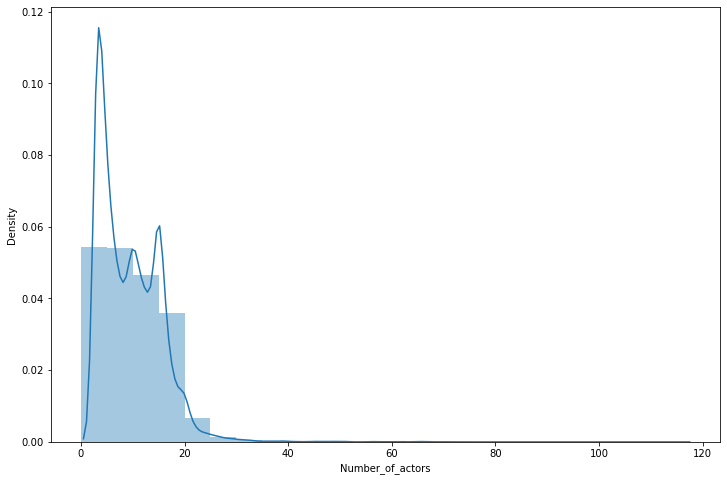

In [9]:
# plot the distribution of the number of actors per movie (histogram interval length = 5)
plt.figure(figsize=(12, 8))
sns.distplot(actors['Number_of_actors'], kde=True, bins=range(0, 120, 5))

In [10]:
# one actor per line in the new dataframe
actors_new_meta = actors.merge(character_metadata[['Character_name', 'Actor_name', 'Wikipedia_movie_ID']], on='Wikipedia_movie_ID', how='inner')

In [11]:
actors_new_meta

,Wikipedia_movie_ID,Actors_names,Number_of_actors,Character_name,Actor_name
0,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14,S-Mart Clerk,Ted Raimi
1,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14,Fake shemp,Ivan Raimi
2,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14,Ash Williams,Bruce Campbell
3,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14,Evil Ash,Bruce Campbell
4,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14,Cowardly Warrior,Ted Raimi
...,...,...,...,...,...
173364,36956792,"[Geraldine Brophy, Bruce Allpress, Edward Camp...",28,Churchill,Sid
173365,37196243,"[Keke Palmer, Aunjanue Ellis, Sherri Shepherd,...",4,Carlina White,Keke Palmer
173366,37196243,"[Keke Palmer, Aunjanue Ellis, Sherri Shepherd,...",4,Ann Pettway,Aunjanue Ellis
173367,37196243,"[Keke Palmer, Aunjanue Ellis, Sherri Shepherd,...",4,Joy White,Sherri Shepherd


## Create actors Network

In [12]:
# dataframe with pairs of actors and the number of movies they acted in together
# the dataframe to merge contains all the actors_new_meta dataframe except the actors_names column
to_merge = actors_new_meta.drop('Actors_names', axis=1)
actors_pairs = to_merge.merge(to_merge, on=['Wikipedia_movie_ID', 'Number_of_actors'], how='inner')
# filter the dataframe to keep only the pairs where the actor names are different
actors_pairs = actors_pairs[actors_pairs['Actor_name_x'] != actors_pairs['Actor_name_y']]
# filter the dataframe to keep only the pairs that are not interchangeable (actor1, actor2) and (actor2, actor1)
actors_pairs = actors_pairs[actors_pairs['Actor_name_x'] < actors_pairs['Actor_name_y']]

In [13]:
# for each pair make a new column with the list of movies they acted in together
actors_pairs_common_movies = actors_pairs.groupby(['Actor_name_x', 'Actor_name_y'])['Wikipedia_movie_ID'].apply(list).reset_index().rename(columns={'Wikipedia_movie_ID': 'Common_movies'})
# remove the duplicates in the movies list
actors_pairs_common_movies['Common_movies'] = actors_pairs_common_movies['Common_movies'].apply(lambda x: list(set(x)))

In [14]:
# number of common movies between each pair of actors
actors_pairs_common_movies['Number_of_common_movies'] = actors_pairs_common_movies['Common_movies'].apply(lambda x: len(x))

In [15]:
# filter the dataframe to keep only the pairs that acted in more than 2 movies together
actors_pairs_common_movies_filtered = actors_pairs_common_movies[actors_pairs_common_movies['Number_of_common_movies'] > 2]

In [16]:
actors_pairs_common_movies_filtered

,Actor_name_x,Actor_name_y,Common_movies,Number_of_common_movies
100,50 Cent,Ambyr Childers,"[24150888, 31738289, 33638321]",3
888,A.K Hangal,Achala Sachdev,"[24490519, 6025381, 10699255]",3
890,A.K Hangal,Amitabh Bachchan,"[10618760, 26748268, 1609520, 5181141, 648216]",5
896,A.K Hangal,Asrani,"[648216, 1609520, 8813317]",3
899,A.K Hangal,Bindu,"[1609520, 10638177, 32281762]",3
...,...,...,...,...
980892,Vince Vaughn,Will Ferrell,"[1385251, 8039722, 709490, 974837, 305909, 547...",6
981511,Wakana Yamazaki,Wataru Takagi,"[8062885, 8830252, 6203032, 11590938, 8950238]",5
981582,Walter Brennan,Ward Bond,"[1934905, 74978, 81100]",3
981630,Walter Koenig,William Shatner,"[88609, 161190, 277006, 145359, 27098, 206879]",6


In [17]:
# create a non directed graph from the dataframe
G = nx.from_pandas_edgelist(actors_pairs_common_movies_filtered, source='Actor_name_x', target='Actor_name_y', edge_attr='Number_of_common_movies')
# show the number of nodes and edges in the graph
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())

Number of nodes:  2631
Number of edges:  7119


In [18]:
# make partitions of the graph 
coms = algorithms.louvain(G, weight='Number_of_common_movies')
# make subgraphs from the partitions
subgraphs = [G.subgraph(c) for c in coms.communities]
# show the number of subgraphs
print('Number of communities: ', len(subgraphs))
# show the number of nodes in each subgraph and the average weight of the edges in each subgraph
for i, subgraph in enumerate(subgraphs):
    print('community ', i + 1, ' number of actors: ', subgraph.number_of_nodes())
    print('community ', i + 1, ' average numbers of movies between actors: ', subgraph.size(weight='Number_of_common_movies') / subgraph.number_of_edges())

Number of communities:  267
community  1  number of actors:  304
community  1  average numbers of movies between actors:  3.996469549867608
community  2  number of actors:  166
community  2  average numbers of movies between actors:  3.8910505836575875
community  3  number of actors:  161
community  3  average numbers of movies between actors:  3.561688311688312
community  4  number of actors:  147
community  4  average numbers of movies between actors:  3.565836298932384
community  5  number of actors:  115
community  5  average numbers of movies between actors:  3.329896907216495
community  6  number of actors:  108
community  6  average numbers of movies between actors:  3.272189349112426
community  7  number of actors:  100
community  7  average numbers of movies between actors:  4.19153031761309
community  8  number of actors:  95
community  8  average numbers of movies between actors:  3.8901734104046244
community  9  number of actors:  92
community  9  average numbers of movies 

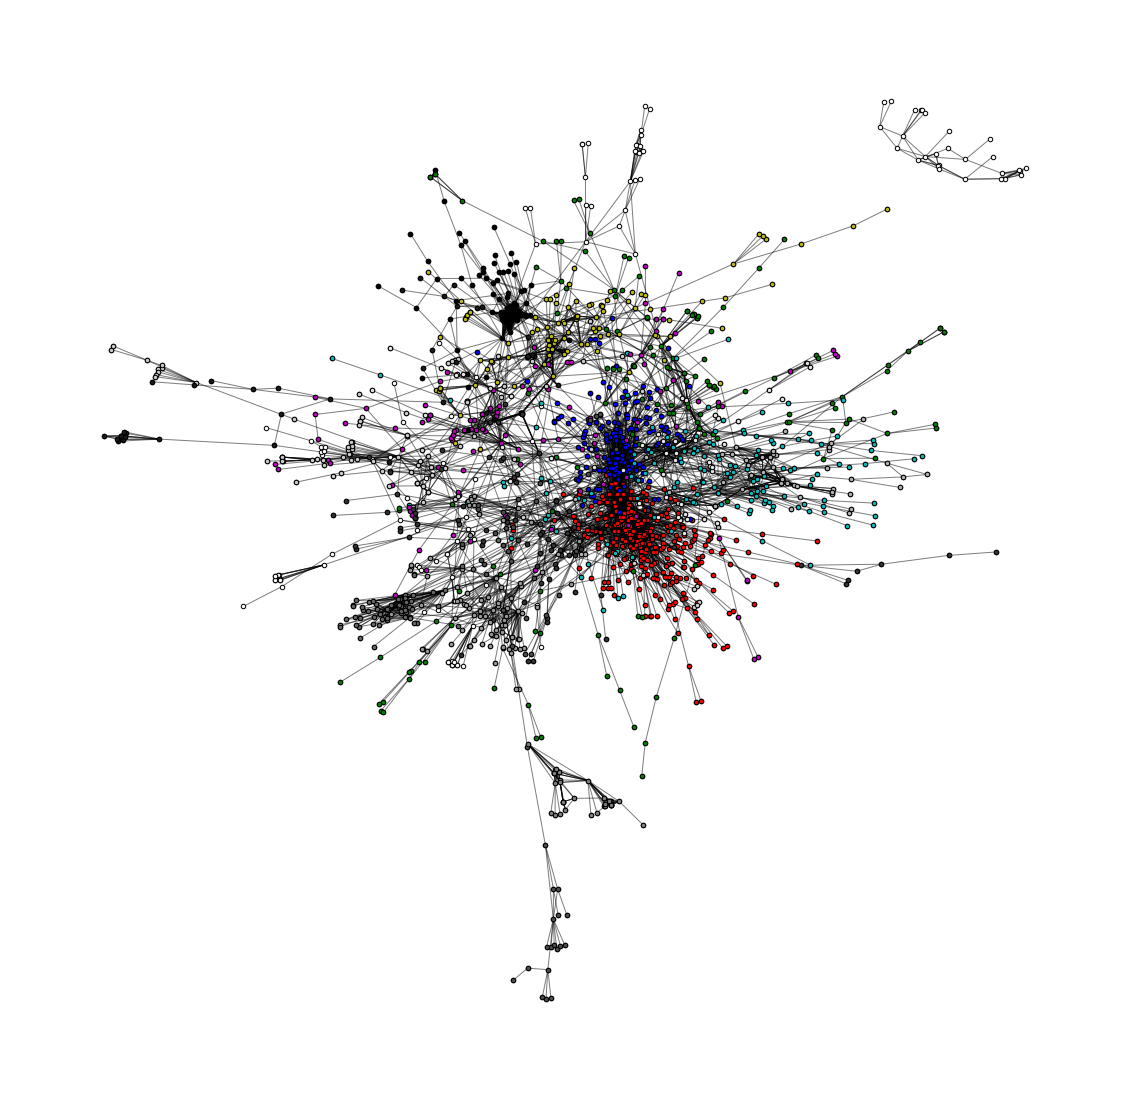

In [19]:
# vizualise the obtained partitions (top 20 communities)
from cdlib import viz
viz.plot_network_clusters(G, coms, node_size=20, figsize=(20, 20), plot_labels=False, top_k=20)

In [20]:
# store the top 20 communities in dataframes
# each row in the dataframe is an actor in the community, the connectivity column represents the total weight of the edges that the actor is connected to
# i.e the total number of movies the actor acted in with the other actors in the community
top_20_communities = []
for i, subgraph in enumerate(subgraphs[:20]):
    top_20_communities.append(pd.DataFrame(subgraph.degree(weight='Number_of_common_movies'), columns=['Actor_name', 'connectivity']).sort_values('connectivity', ascending=False))

In [21]:
# for each community add columns for actors ethnicity, gender and date of birth from the character_metadata dataframe
for i, community in enumerate(top_20_communities):
    top_20_communities[i] = community.merge(character_metadata[['Actor_name','actor_gender', 'Actor_date_of_birth', 'Actor_ethnicity']], on='Actor_name', how='inner').drop_duplicates(subset=['Actor_name']).reset_index(drop=True)
    


In [22]:
top_20_communities[5]

,Actor_name,connectivity,actor_gender,Actor_date_of_birth,Actor_ethnicity
0,Christopher Lee,98,M,1922-05-27,NaN
1,Orlando Bloom,89,M,1977-01-13,/m/02w7gg
2,Ian McKellen,85,M,1939-05-25,NaN
3,Hugo Weaving,78,M,1960-04-04,NaN
4,Andy Serkis,69,M,1964-04-20,NaN
...,...,...,...,...,...
103,Maria Rohm,3,F,1945-08-13,NaN
104,Jacek Koman,3,M,1956-08-15,NaN
105,Ray Stevenson,3,M,1964-05-25,/m/0d7wh
106,Glenn Shadix,3,M,1952-04-15,NaN
